In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import polars as pl
from typing import List, Optional
import networkx.algorithms.bipartite as nxbp

In [2]:
def load_lazy(path: str,separator:str,list_sep=",", schema: dict = None,has_header=True, null_values="\\N") -> pl.LazyFrame:
    """
    Lazily load a CSV/TSV using Polars, respecting schema and nulls.
    Automatically parses columns typed as List(Utf8) using str.split(',')

    Args:
        path: Path to TSV/CSV
        separator: Single byte character to use as separator in the file
        list_sep: String used to seperate list values in the file
        schema: Optional dict of column_name -> pl.DataType
        has_header: Indicate if the first row of the dataset is a header or not
        null_values: String or list of strings representing nulls

    Returns:
        pl.LazyFrame
    """
    load_schema = {
    k: (v.inner if isinstance(v, pl.List) else v)
    for k, v in schema.items()
}
    df_lazy = pl.scan_csv(
        path,
        separator=separator,
        null_values=null_values,
        has_header=has_header,
        quote_char=None,
        schema_overrides=load_schema,
    )
    if schema is not None:
        # Detect all list columns in schema
        list_cols = [col for col, dtype in schema.items() if isinstance(dtype, pl.List)]
        print(list_cols)
        if list_cols:
            # Apply str.split to all list columns lazily
            df_lazy = df_lazy.with_columns(
                [pl.col(c).str.split(list_sep) for c in list_cols]
            )

    return df_lazy


def collect_if_lazy(df):
    if(isinstance(df,pl.LazyFrame)):
        df = df.collect()
    return df

In [54]:
from matplotlib.lines import Line2D


def draw_graph(
    G,
    groups=None,
    *,
    title=None,
    seed=42,
    node_spacing=1,
    node_color="lightblue",
    node_size=500,
    show_legend="auto",
    outline_nodes=True,
    fill_nodes=False,
    layout="spring",
    figsize=(10, 8),
    groups_edge_style="solid",
    default_edge_style="dotted",
    default_edge_color="gray",
    default_colors=None,
    node_labels_key=None,
    min_edge_width=1,
    max_edge_width=1.005,
    edge_weight_key="weight",
    font_size=9,
    font_weight="normal",
    font_color="k",
    bbox=None
):
    """
    Draw a graph emphasizing arbitrary groups of nodes and/or edges.

    Parameters
    ----------
    G : networkx.Graph
        Graph to draw.
    groups : list of dict
        Each dict represents a group with optional keys:
            - 'nodes': list of nodes to emphasize
            - 'edges': list of edges (tuples) to emphasize
            - 'color': color for this group (optional)
            - 'label': label of this group (optional), defaults to Group {index of this group}
    title : str, optional
        Figure title.
    seed : int
        Random seed for layout.
    node_spacing : int
        Spacing between nodes.
    node_color : str
        Fill color for nodes.
    node_size : int
        Node size.
    show_legend : bool | "auto"
        Show legend.
    outline_nodes : bool
        If True, nodes in groups get colored outlines.
    fill_nodes : bool
        If True, nodes in groups get colored fill.
    layout : str
        "kamada_kawai" or "spring".
    figsize : tuple
        Figure size.
    groups_edge_style: str
        Style of edges in groups.
    default_edge_style: str
        Default style of edges.
    default_edge_color: str
        Default color of all edges.
    default_colors : sequence, optional
        Sequence of colors to use for groups without specified color.
    node_labels_key : str
        Attribute which should be used as node name instead of node id.
    min_edge_width: int
        Minimal width of an edge.
    max_edge_width: int
        Maximal width of an edge.
    edge_weight_key: str | None
        Attribute used for edge width calculation
    font_size : int or dictionary of nodes to ints (default=12)
        Font size for text labels.
    font_color : color or dictionary of nodes to colors (default='k' black)
        Font color string. Color can be string or rgb (or rgba) tuple of floats from 0-1.
    font_weight : string or dictionary of nodes to strings (default='normal')
        Font weight.
    bbox : dict | None
         Matplotlib bbox, (default is Matplotlib's ax.text default)
        Specify text box properties (e.g. shape, color etc.) for node labels.
    """

    if default_colors is None:
        default_colors = plt.cm.tab10.colors

    # ---------- Layout ----------
    if layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G,scale=node_spacing)
    elif layout == "spring":
        pos = nx.spring_layout(G, seed=seed, k=node_spacing * 1.5 / (G.number_of_nodes() ** 0.5))
    else:
        raise ValueError(f"Unsupported layout: {layout}")

    plt.figure(figsize=figsize)

    grouped_nodes = set()
    grouped_edges = set()
    legend_handles = []

    def get_edges_width(G,edges):
        width = min_edge_width
        if(edge_weight_key != None):
            edge_width_len = max_edge_width - min_edge_width

            def get_edge_weight(edge):
                weight = edge.get(edge_weight_key)
                return weight if weight != None else 0
                
            
            width = list(map(lambda edge: 
                        min_edge_width + int(get_edge_weight(G.edges[edge[0],edge[1]])) * edge_width_len,
                            edges
                            ))
        return width

    # ---------- Draw groups ----------
    if groups:
        for i, group in enumerate(groups):
            color = group.get("color", default_colors[i % len(default_colors)])
            nodes = group.get("nodes", [])
            edges = group.get("edges", [])
            label = group.get("label",f"Group {i+1}")

            # Draw edges
            if edges:
                nx.draw_networkx_edges(
                    G, pos,
                    edgelist=edges,
                    width=get_edges_width(G,edges),
                    edge_color=[color]*len(edges),
                    style=groups_edge_style,
                    label=label
                )
                grouped_edges.update(edges)
                legend_handles.append(Line2D([], [], color=color, label=label))

            # Draw nodes
            if nodes:
                nodes_label=None if edges else label
                nx.draw_networkx_nodes(
                    G, pos,
                    nodelist=nodes,
                    node_color=color if fill_nodes else node_color,
                    edgecolors=color if outline_nodes else default_edge_color,
                    linewidths=2 if outline_nodes else 1,
                    node_size=node_size,
                    label=nodes_label
                )
                grouped_nodes.update(nodes)
            
            


    # ---------- Draw remaining edges ----------
    other_edges = [e for e in G.edges() if e not in grouped_edges]
    nx.draw_networkx_edges(G, pos, edgelist=other_edges,
                           style=default_edge_style, 
                           width=get_edges_width(G,other_edges),
                           edge_color=default_edge_color)

    # ---------- Draw remaining nodes ----------
    other_nodes = [n for n in G.nodes() if n not in grouped_nodes]
    nx.draw_networkx_nodes(G, pos, nodelist=other_nodes,
                           node_color=node_color,
                           edgecolors=default_edge_color,
                           linewidths=1,
                           node_size=node_size)

    # ---------- Labels and legend ----------
    labels = {node:name for node,name in G.nodes(data=node_labels_key)}
    for node in G.nodes():
        if labels.get(node) == None:
            labels[node]=node
    nx.draw_networkx_labels(G, 
                            pos,
                            labels=labels, 
                            font_size=font_size,
                            font_weight=font_weight,
                            font_color=font_color,
                            bbox=bbox)
    if show_legend is True or (show_legend == "auto" and groups and len(groups) > 1):
        plt.legend(frameon=False)
    if title:
        plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


In [4]:
def draw_tripartite(G, type_attr="type"):
    # Map type → index for multipartite_layout
    type_to_idx = {"actor": 0, "film": 1, "genre": 2}

    subset_color = ["gold", "violet", "darkorange"]

    # Colors per node
    color = [
        subset_color[type_to_idx[data[type_attr]]]
        for v, data in G.nodes(data=True)
    ]

    # Convert type strings → integers in a new attribute
    H = G.copy()
    for n, data in H.nodes(data=True):
        data["subset"] = type_to_idx[data[type_attr]]

    pos = nx.multipartite_layout(H, subset_key="subset")

    plt.figure(figsize=(10, 10), constrained_layout=True)
    nx.draw(H, pos, node_color=color, node_size=120, width=0.4)
    plt.show()


In [5]:
def draw_tripartite_grid(
    G,
    type_attr="type",
    order=("actor", "film", "genre"),
    max_rows=25,
    x_padding=2.5,
    y_padding=5,
    col_padding=0.1,
    node_size=120,
    label=False,
):
    import matplotlib.pyplot as plt

    # partition nodes
    parts = {t: [] for t in order}
    for n, d in G.nodes(data=True):
        t = d.get(type_attr)
        if t in parts:
            parts[t].append(n)

    pos = {}

    # layout each partition
    for part_index, t in enumerate(order):
        nodes = parts[t]
        x_base = part_index * x_padding

        col_count = len(nodes) // max_rows
        for idx, node in enumerate(nodes):
            
            col = idx // max_rows       # which small column inside the partition
            row = idx % max_rows        # vertical position inside that column

            x = x_base + col * col_padding
            y = row * y_padding + (col % 2) * y_padding

            pos[node] = (x, y)

    # coloring
    colormap = {
        "actor": "#4C72B0",
        "film":  "#55A868",
        "genre": "#C44E52",
    }
    colors = [colormap[G.nodes[n][type_attr]] for n in G.nodes()]

    plt.figure(figsize=(16, 10), constrained_layout=True)
    nx.draw(
        G,
        pos,
        node_size=node_size,
        node_color=colors,
        width=0.4,
        with_labels=label,
        font_size=7,
    )
    plt.show()


In [6]:
import math
import matplotlib.pyplot as plt
import networkx as nx

def draw_multipartite_large(G, type_attr="type", max_nodes_per_column=30, x_spacing=3, y_spacing=1):
    """
    Draws multipartite graph with smart grouping:
    - nodes grouped by type_attr
    - large groups split into vertical blocks
    - blocks arranged horizontally
    """

    # Step 1: collect groups
    groups = {}
    for node, data in G.nodes(data=True):
        g = data[type_attr]
        groups.setdefault(g, []).append(node)

    # Assign deterministic left-to-right ordering
    group_order = sorted(groups.keys())

    pos = {}

    # Step 2: build positions
    current_x = 0

    for g in group_order:
        nodes = groups[g]
        n = len(nodes)

        # how many vertical columns for this group?
        columns = math.ceil(n / max_nodes_per_column)

        for col in range(columns):
            start = col * max_nodes_per_column
            end = min(start + max_nodes_per_column, n)

            column_nodes = nodes[start:end]

            # x-position of this block
            x = current_x + col * x_spacing

            # distribute nodes vertically
            for i, node in enumerate(column_nodes):
                y = -i * y_spacing
                pos[node] = (x, y)

        # move right after finishing the group
        current_x += (columns + 1) * x_spacing

    # Step 3: draw
    plt.figure(figsize=(16, 10))
    nx.draw(G, pos, with_labels=False, node_size=80, edge_color="gray")
    plt.axis("equal")


In [7]:
def get_graph_metrics(G):
    bridges = list(nx.bridges(G))
    articulations = list(nx.articulation_points(G))
    components = list(nx.connected_components(G))
    cliques = nx.find_cliques(G)
    cliques_number=max(map(lambda clique: len(clique),cliques))
    return {
        "Počet uzlů":len(nx.nodes(G)),
        "Tranzitivita":nx.transitivity(G),
        "Hustota":nx.density(G),
        "Klikovost":cliques_number,
        "Průměrný clustering": nx.average_clustering(G),
        "Počet artikulací":len(articulations),
        "Počet mostů":len(bridges),
        "Počet komponent": len(components),
        "Počet klik":len(cliques),
        "Kliky":cliques,
        "Artikulace":articulations,
        "Mosty":bridges,
    }

def get_graph_metrics_df(G):
    return pl.DataFrame([get_graph_metrics(G)])

In [ ]:
def count_cliques_by_vertex(G,cliques):
    clique_count_by_vertex = {node:0 for node in G.nodes()}
    for clique in cliques:
        for node in clique:
            clique_count_by_vertex[node]+=1
    return clique_count_by_vertex

In [ ]:
def get_nodes_metrics_df(G,cliques=None):
    degree_dict = dict(G.degree())
    eigen_vector_dict = nx.eigenvector_centrality(G)
    betweenness_dict = nx.betweenness_centrality(G)
    closeness_dict = nx.closeness_centrality(G)
    clustering_dict = nx.clustering(G)
    clique_count_by_vertex = count_cliques_by_vertex(G,cliques if cliques != None else nx.find_cliques(cliques))

    # Build DataFrame
    df = pd.DataFrame({
        "uzel": list(G.nodes()),
        "klikovost": [clique_count_by_vertex[n] for n in G.nodes()],
        "degree": [degree_dict[n] for n in G.nodes()],
        "eigen-vector": [eigen_vector_dict[n] for n in G.nodes()],
        "betweenness": [betweenness_dict[n] for n in G.nodes()],
        "closeness": [closeness_dict[n] for n in G.nodes()],
        "clustering":[clustering_dict[n] for n in G.nodes()]
    })
    df_metrics = get_graph_metrics_df(G)
    display(df_metrics)
    display(df.sort_values("klikovost",ascending=False).style.hide(axis="index"))

# Analýza sítě 100 nejvýdělečnějších herců a jejich žánrů


## Obsah
1. Načtení a filtrace dat
2. Analýza projekce herců
3. Analýza projekce žánrů

## 1. Načtení a filtrace dat¨
Data jsou uloženy v složce ./data/original_data a to jako 3 obrovské soubory ve formátu tsv a jeden malý soubor ve formátu csv oddělený ';'.
title.basics.tsv - obsahuje informace o filmech a jejich žánrech ~1GB
name.basics.tsv - obsahuje informace o hercích ~0,9GB
title.principals.tsv - přiřazuje herce k filmům na základě hereckého obsazení filmů ~4,2GB
popular_actors.csv - obsahuje informace o nejvýdělečnějších hercích ~11KB¨

Z důvodu takto obrovského množství dat vyberu pouze 100 nejvýdělečnějších žijících herců z popular_actors.csv a najdu je v name.basics.tsv a následně načtu jejich filmy skrze title.principals.tsv.

A nakonec takto vyfiltrovaná data uložím do nových souborů aby bylo příští načtení a zpracování rychlejší.


### 1. Zjištění informací o datasetu

## Films

In [8]:

ORIGINAL_DATA_PATH="./data/original_data"
df_films = load_lazy(
        path=ORIGINAL_DATA_PATH + "/title.basics.tsv",
        separator="\t",
        schema={
    "tconst": pl.Utf8,
    "titleType": pl.Utf8,
    "primaryTitle": pl.Utf8,
    "originalTitle": pl.Utf8,
    "isAdult": pl.Int64,
    "startYear": pl.Int64,
    "endYear": pl.Int64,
    "runtimeMinutes": pl.Int64,
    "genres": pl.List(pl.Utf8),
},
    )

df_ratings = load_lazy(path=ORIGINAL_DATA_PATH + "/title.ratings.tsv",
                       separator="\t",
        schema={
    "tconst": pl.Utf8,
    "averageRating": pl.Float32,
    "numVotes": pl.Int64,
})
df_films = df_films.join(df_ratings,on="tconst").filter(
    pl.col("titleType").eq("movie"),
    pl.col("runtimeMinutes").is_between(60,300),
    pl.col("genres").len().gt(0),
    pl.col("endYear").is_null()
    ).drop(["endYear","titleType","originalTitle"])\
    .drop_nulls()\
    .rename({"startYear":"year"})

display(df_films.describe())
display(df_films.head().collect())


['genres']
[]


shape: (9, 9)
┌────────────┬───────────┬───────────┬──────────┬───┬───────────┬──────────┬───────────┬───────────┐
│ statistic  ┆ tconst    ┆ primaryTi ┆ isAdult  ┆ … ┆ runtimeMi ┆ genres   ┆ averageRa ┆ numVotes  │
│ ---        ┆ ---       ┆ tle       ┆ ---      ┆   ┆ nutes     ┆ ---      ┆ ting      ┆ ---       │
│ str        ┆ str       ┆ ---       ┆ f64      ┆   ┆ ---       ┆ f64      ┆ ---       ┆ f64       │
│            ┆           ┆ str       ┆          ┆   ┆ f64       ┆          ┆ f64       ┆           │
╞════════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪══════════╪═══════════╪═══════════╡
│ count      ┆ 279647    ┆ 279647    ┆ 279647.0 ┆ … ┆ 279647.0  ┆ 279647.0 ┆ 279647.0  ┆ 279647.0  │
│ null_count ┆ 0         ┆ 0         ┆ 0.0      ┆ … ┆ 0.0       ┆ 0.0      ┆ 0.0       ┆ 0.0       │
│ mean       ┆ null      ┆ null      ┆ 0.012587 ┆ … ┆ 96.171852 ┆ null     ┆ 6.087477  ┆ 4403.6034 │
│            ┆           ┆           ┆          ┆   ┆           ┆          ┆           ┆ 72        │
│ std        ┆ null      ┆ null      ┆ 0.111485 ┆ … ┆ 21.917784 ┆ null     ┆ 1.332406  ┆ 40911.126 │
│            ┆           ┆           ┆          ┆   ┆           ┆          ┆           ┆ 33        │
│ min        ┆ tt0000147 ┆ !Women    ┆ 0.0      ┆ … ┆ 60.0      ┆ null     ┆ 1.0       ┆ 5.0       │
│            ┆           ┆ Art Revol ┆          ┆   ┆           ┆          ┆           ┆           │
│            ┆           ┆ ution     ┆          ┆   ┆           ┆          ┆           ┆           │
│ 25%        ┆ null      ┆ null      ┆ 0.0      ┆ … ┆ 83.0      ┆ null     ┆ 5.3       ┆ 26.0      │
│ 50%        ┆ null      ┆ null      ┆ 0.0      ┆ … ┆ 92.0      ┆ null     ┆ 6.2       ┆ 93.0      │
│ 75%        ┆ null      ┆ null      ┆ 0.0      ┆ … ┆ 105.0     ┆ null     ┆ 7.0       ┆ 458.0     │
│ max        ┆ tt9916730 ┆ ärtico    ┆ 1.0      ┆ … ┆ 300.0     ┆ null     ┆ 10.0      ┆ 3.120678e │
│            ┆           ┆           ┆          ┆   ┆           ┆          ┆           ┆ 6         │
└────────────┴───────────┴───────────┴──────────┴───┴───────────┴──────────┴───────────┴───────────┘

shape: (5, 8)
┌───────────┬──────────────┬─────────┬──────┬──────────────┬──────────────┬─────────────┬──────────┐
│ tconst    ┆ primaryTitle ┆ isAdult ┆ year ┆ runtimeMinut ┆ genres       ┆ averageRati ┆ numVotes │
│ ---       ┆ ---          ┆ ---     ┆ ---  ┆ es           ┆ ---          ┆ ng          ┆ ---      │
│ str       ┆ str          ┆ i64     ┆ i64  ┆ ---          ┆ list[str]    ┆ ---         ┆ i64      │
│           ┆              ┆         ┆      ┆ i64          ┆              ┆ f32         ┆          │
╞═══════════╪══════════════╪═════════╪══════╪══════════════╪══════════════╪═════════════╪══════════╡
│ tt0000147 ┆ The Corbett- ┆ 0       ┆ 1897 ┆ 100          ┆ ["Documentar ┆ 5.3         ┆ 577      │
│           ┆ Fitzsimmons  ┆         ┆      ┆              ┆ y", "News",  ┆             ┆          │
│           ┆ Fight        ┆         ┆      ┆              ┆ "Sport…      ┆             ┆          │
│ tt0000574 ┆ The Story of ┆ 0       ┆ 1906 ┆ 70           ┆ ["Action",   ┆ 6.0         ┆ 1037     │
│           ┆ the Kelly    ┆         ┆      ┆              ┆ "Adventure", ┆             ┆          │
│           ┆ Gang         ┆         ┆      ┆              ┆ "Biogr…      ┆             ┆          │
│ tt0000591 ┆ The Prodigal ┆ 0       ┆ 1907 ┆ 90           ┆ ["Drama"]    ┆ 5.1         ┆ 36       │
│           ┆ Son          ┆         ┆      ┆              ┆              ┆             ┆          │
│ tt0000679 ┆ The          ┆ 0       ┆ 1908 ┆ 120          ┆ ["Adventure" ┆ 5.0         ┆ 82       │
│           ┆ Fairylogue   ┆         ┆      ┆              ┆ , "Fantasy"] ┆             ┆          │
│           ┆ and          ┆         ┆      ┆              ┆              ┆             ┆          │
│           ┆ Radio-Plays  ┆         ┆      ┆              ┆              ┆             ┆          │
│ tt0001790 ┆ Les          ┆ 0       ┆ 1913 ┆ 60           ┆ ["Drama"]    ┆ 5.9         ┆ 63       │
│           ┆ Misérables,  ┆         ┆      ┆              ┆              ┆             ┆          │
│           ┆ Part 1: Jean ┆         ┆      ┆              ┆              ┆             ┆          │
│           ┆ V…           ┆         ┆      ┆              ┆              ┆             ┆          │
└───────────┴──────────────┴─────────┴──────┴──────────────┴──────────────┴─────────────┴──────────┘

## Principals

In [9]:

df_principals=load_lazy(path= ORIGINAL_DATA_PATH+"/title.principals.tsv",
                        separator="\t",
                      schema={
                          "tconst":pl.Utf8,
                          "ordering":pl.Int32,
                          "ncosnt":pl.Utf8,
                          "category":pl.Utf8,
                          "job":pl.Utf8,
                          "characters":pl.Utf8
                      })
df_principals = df_principals.filter(pl.col("category").is_in(["actor","actress"]))\
.drop(["category","job","ordering"])\
.rename({"ncosnt":"nconst"})

pl.Config.set_tbl_rows(1000)
display(df_principals.describe())
display(df_principals.head().collect())




[]


shape: (9, 4)
┌────────────┬───────────┬───────────┬──────────────────────────────┐
│ statistic  ┆ tconst    ┆ nconst    ┆ characters                   │
│ ---        ┆ ---       ┆ ---       ┆ ---                          │
│ str        ┆ str       ┆ str       ┆ str                          │
╞════════════╪═══════════╪═══════════╪══════════════════════════════╡
│ count      ┆ 39939406  ┆ 39939406  ┆ 31997728                     │
│ null_count ┆ 0         ┆ 0         ┆ 7941678                      │
│ mean       ┆ null      ┆ null      ┆ null                         │
│ std        ┆ null      ┆ null      ┆ null                         │
│ min        ┆ tt0000005 ┆ nm0000001 ┆ ["!CF"]                      │
│ 25%        ┆ null      ┆ null      ┆ null                         │
│ 50%        ┆ null      ┆ null      ┆ null                         │
│ 75%        ┆ null      ┆ null      ┆ null                         │
│ max        ┆ tt9916880 ┆ nm9993709 ┆ ["🐑 Sheepish Bystander #1"] │
└────────────┴───────────┴───────────┴──────────────────────────────┘

shape: (5, 3)
┌───────────┬───────────┬──────────────────┐
│ tconst    ┆ nconst    ┆ characters       │
│ ---       ┆ ---       ┆ ---              │
│ str       ┆ str       ┆ str              │
╞═══════════╪═══════════╪══════════════════╡
│ tt0000005 ┆ nm0443482 ┆ ["Blacksmith"]   │
│ tt0000005 ┆ nm0653042 ┆ ["Assistant"]    │
│ tt0000007 ┆ nm0179163 ┆ null             │
│ tt0000007 ┆ nm0183947 ┆ null             │
│ tt0000008 ┆ nm0653028 ┆ ["Sneezing Man"] │
└───────────┴───────────┴──────────────────┘

## Actors

In [10]:
df_popular_actors = load_lazy(path= ORIGINAL_DATA_PATH+"/popular_actors.csv",
                      separator=";",
                      schema={
                          "Rank":pl.UInt32,
                          "Name":pl.Utf8,
                          "DomesticBox":pl.Utf8,
                          "Office":pl.Utf8,
                          "Movies":pl.UInt32,
                          "Average":pl.Utf8,
                          "BirthYear":pl.UInt16
                      }).sort("Rank").select(["Name","BirthYear"]).rename({
                          "Name":"primaryName",
                          "BirthYear":"birthYear"
                          }).drop_nulls()
display(df_popular_actors.describe())
display(df_popular_actors.head().collect())


[]


shape: (9, 3)
┌────────────┬──────────────────────┬───────────┐
│ statistic  ┆ primaryName          ┆ birthYear │
│ ---        ┆ ---                  ┆ ---       │
│ str        ┆ str                  ┆ f64       │
╞════════════╪══════════════════════╪═══════════╡
│ count      ┆ 200                  ┆ 200.0     │
│ null_count ┆ 0                    ┆ 0.0       │
│ mean       ┆ null                 ┆ 1968.205  │
│ std        ┆ null                 ┆ 14.698408 │
│ min        ┆ Aaron Taylor-Johnson ┆ 1925.0    │
│ 25%        ┆ null                 ┆ 1960.0    │
│ 50%        ┆ null                 ┆ 1969.0    │
│ 75%        ┆ null                 ┆ 1979.0    │
│ max        ┆ Zoe Saldaña          ┆ 1996.0    │
└────────────┴──────────────────────┴───────────┘

shape: (5, 2)
┌────────────────────┬───────────┐
│ primaryName        ┆ birthYear │
│ ---                ┆ ---       │
│ str                ┆ u16       │
╞════════════════════╪═══════════╡
│ Samuel L. Jackson  ┆ 1948      │
│ Scarlett Johansson ┆ 1984      │
│ Robert Downey, Jr. ┆ 1965      │
│ Chris Pratt        ┆ 1979      │
│ Tom Hanks          ┆ 1956      │
└────────────────────┴───────────┘

In [11]:
df_actors = load_lazy(path= ORIGINAL_DATA_PATH+"/name.basics.tsv",
                      separator="\t",
                      schema={
                          "nconst":pl.Utf8,
                          "primaryName":pl.Utf8,
                          "birthYear":pl.Int16,
                          "deathYear":pl.Int16,
                          "primaryProfession":pl.List(pl.Utf8),
                          "knownForTitles":pl.List(pl.Utf8)
                      })

df_actors = df_actors
display(df_actors.head().collect())
display(df_actors.describe())


['primaryProfession', 'knownForTitles']


shape: (5, 6)
┌───────────┬─────────────────┬───────────┬───────────┬──────────────────────┬─────────────────────┐
│ nconst    ┆ primaryName     ┆ birthYear ┆ deathYear ┆ primaryProfession    ┆ knownForTitles      │
│ ---       ┆ ---             ┆ ---       ┆ ---       ┆ ---                  ┆ ---                 │
│ str       ┆ str             ┆ i16       ┆ i16       ┆ list[str]            ┆ list[str]           │
╞═══════════╪═════════════════╪═══════════╪═══════════╪══════════════════════╪═════════════════════╡
│ nm0000001 ┆ Fred Astaire    ┆ 1899      ┆ 1987      ┆ ["actor",            ┆ ["tt0072308",       │
│           ┆                 ┆           ┆           ┆ "miscellaneous",     ┆ "tt0050419", … "…   │
│           ┆                 ┆           ┆           ┆ "pr…                 ┆                     │
│ nm0000002 ┆ Lauren Bacall   ┆ 1924      ┆ 2014      ┆ ["actress",          ┆ ["tt0037382",       │
│           ┆                 ┆           ┆           ┆ "miscellaneous", "…  ┆ "tt0075213", … "…   │
│ nm0000003 ┆ Brigitte Bardot ┆ 1934      ┆ null      ┆ ["actress",          ┆ ["tt0057345",       │
│           ┆                 ┆           ┆           ┆ "music_department"…  ┆ "tt0049189", … "…   │
│ nm0000004 ┆ John Belushi    ┆ 1949      ┆ 1982      ┆ ["actor", "writer",  ┆ ["tt0072562",       │
│           ┆                 ┆           ┆           ┆ "music_dep…          ┆ "tt0077975", … "…   │
│ nm0000005 ┆ Ingmar Bergman  ┆ 1918      ┆ 2007      ┆ ["writer",           ┆ ["tt0050986",       │
│           ┆                 ┆           ┆           ┆ "director", "actor"… ┆ "tt0069467", … "…   │
└───────────┴─────────────────┴───────────┴───────────┴──────────────────────┴─────────────────────┘

shape: (9, 7)
┌────────────┬───────────┬───────────────┬─────────────┬─────────────┬──────────────┬──────────────┐
│ statistic  ┆ nconst    ┆ primaryName   ┆ birthYear   ┆ deathYear   ┆ primaryProfe ┆ knownForTitl │
│ ---        ┆ ---       ┆ ---           ┆ ---         ┆ ---         ┆ ssion        ┆ es           │
│ str        ┆ str       ┆ str           ┆ f64         ┆ f64         ┆ ---          ┆ ---          │
│            ┆           ┆               ┆             ┆             ┆ f64          ┆ f64          │
╞════════════╪═══════════╪═══════════════╪═════════════╪═════════════╪══════════════╪══════════════╡
│ count      ┆ 14877235  ┆ 14877168      ┆ 658994.0    ┆ 251220.0    ┆ 1.1915829e7  ┆ 1.3130004e7  │
│ null_count ┆ 0         ┆ 67            ┆ 1.4218241e7 ┆ 1.4626015e7 ┆ 2.961406e6   ┆ 1.747231e6   │
│ mean       ┆ null      ┆ null          ┆ 1954.304578 ┆ 1994.655139 ┆ null         ┆ null         │
│ std        ┆ null      ┆ null          ┆ 35.575006   ┆ 36.548684   ┆ null         ┆ null         │
│ min        ┆ nm0000001 ┆ !'aru Ikhuisi ┆ 4.0         ┆ 17.0        ┆ null         ┆ null         │
│            ┆           ┆ Piet Berendse ┆             ┆             ┆              ┆              │
│ 25%        ┆ null      ┆ null          ┆ 1933.0      ┆ 1981.0      ┆ null         ┆ null         │
│ 50%        ┆ null      ┆ null          ┆ 1961.0      ┆ 2003.0      ┆ null         ┆ null         │
│ 75%        ┆ null      ┆ null          ┆ 1980.0      ┆ 2016.0      ┆ null         ┆ null         │
│ max        ┆ nm9993719 ┆ ﻿Thesia        ┆ 2025.0      ┆ 2025.0      ┆ null         ┆ null         │
│            ┆           ┆ Kouloungou    ┆             ┆             ┆              ┆              │
└────────────┴───────────┴───────────────┴─────────────┴─────────────┴──────────────┴──────────────┘

Teď se pousíme vyhledat populární herce v imdb datasetu podle jejich jmen.

In [12]:
df_popular_actors_100 = df_popular_actors.limit(100)
df_actors_filtered_popular = df_popular_actors_100.lazy().join(df_actors,on=["primaryName", "birthYear"], how="left").collect()

print("Populární herci dle jména a roku narození")
display(df_actors_filtered_popular.describe())

Populární herci dle jména a roku narození


shape: (9, 7)
┌────────────┬─────────────┬───────────┬───────────┬───────────┬──────────────────┬────────────────┐
│ statistic  ┆ primaryName ┆ birthYear ┆ nconst    ┆ deathYear ┆ primaryProfessio ┆ knownForTitles │
│ ---        ┆ ---         ┆ ---       ┆ ---       ┆ ---       ┆ n                ┆ ---            │
│ str        ┆ str         ┆ f64       ┆ str       ┆ f64       ┆ ---              ┆ f64            │
│            ┆             ┆           ┆           ┆           ┆ f64              ┆                │
╞════════════╪═════════════╪═══════════╪═══════════╪═══════════╪══════════════════╪════════════════╡
│ count      ┆ 100         ┆ 100.0     ┆ 96        ┆ 2.0       ┆ 96.0             ┆ 96.0           │
│ null_count ┆ 0           ┆ 0.0       ┆ 4         ┆ 98.0      ┆ 4.0              ┆ 4.0            │
│ mean       ┆ null        ┆ 1968.88   ┆ null      ┆ 2017.0    ┆ null             ┆ null           │
│ std        ┆ null        ┆ 13.76959  ┆ null      ┆ 4.242641  ┆ null             ┆ null           │
│ min        ┆ Adam Driver ┆ 1930.0    ┆ nm0000093 ┆ 2014.0    ┆ null             ┆ null           │
│ 25%        ┆ null        ┆ 1962.0    ┆ null      ┆ 2014.0    ┆ null             ┆ null           │
│ 50%        ┆ null        ┆ 1969.0    ┆ null      ┆ 2020.0    ┆ null             ┆ null           │
│ 75%        ┆ null        ┆ 1979.0    ┆ null      ┆ 2020.0    ┆ null             ┆ null           │
│ max        ┆ Zoe Saldaña ┆ 1996.0    ┆ nm5397459 ┆ 2020.0    ┆ null             ┆ null           │
└────────────┴─────────────┴───────────┴───────────┴───────────┴──────────────────┴────────────────┘

Jak lze vidět, tak 2 jsou již po smrti a 4 herci chybí.

In [13]:
display(df_actors_filtered_popular.filter(pl.col("deathYear").is_not_null()))

shape: (2, 6)
┌──────────────────┬───────────┬───────────┬───────────┬─────────────────────┬─────────────────────┐
│ primaryName      ┆ birthYear ┆ nconst    ┆ deathYear ┆ primaryProfession   ┆ knownForTitles      │
│ ---              ┆ ---       ┆ ---       ┆ ---       ┆ ---                 ┆ ---                 │
│ str              ┆ u16       ┆ str       ┆ i16       ┆ list[str]           ┆ list[str]           │
╞══════════════════╪═══════════╪═══════════╪═══════════╪═════════════════════╪═════════════════════╡
│ Chadwick Boseman ┆ 1976      ┆ nm1569276 ┆ 2020      ┆ ["actor",           ┆ ["tt1825683",       │
│                  ┆           ┆           ┆           ┆ "producer",         ┆ "tt2473602", … "…   │
│                  ┆           ┆           ┆           ┆ "writer"…           ┆                     │
│ Robin Williams   ┆ 1951      ┆ nm0000245 ┆ 2014      ┆ ["actor", "writer", ┆ ["tt0107614",       │
│                  ┆           ┆           ┆           ┆ "producer"…         ┆ "tt0093105", … "…   │
└──────────────────┴───────────┴───────────┴───────────┴─────────────────────┴─────────────────────┘

Výše lze vidět mrtvé herce.
Kvůli tomu přidáme další 2.

In [14]:
df_popular_actors_100_102 = df_popular_actors.slice(100,2)
df_actors_filtered_popular_sub = df_popular_actors_100_102.join(
    df_actors,
    on=["primaryName", "birthYear"], 
    how="left"
    ).collect()
display(df_actors_filtered_popular_sub)

shape: (2, 6)
┌────────────────┬───────────┬───────────┬───────────┬─────────────────────────┬───────────────────┐
│ primaryName    ┆ birthYear ┆ nconst    ┆ deathYear ┆ primaryProfession       ┆ knownForTitles    │
│ ---            ┆ ---       ┆ ---       ┆ ---       ┆ ---                     ┆ ---               │
│ str            ┆ u16       ┆ str       ┆ i16       ┆ list[str]               ┆ list[str]         │
╞════════════════╪═══════════╪═══════════╪═══════════╪═════════════════════════╪═══════════════════╡
│ Brie Larson    ┆ 1989      ┆ nm0488953 ┆ null      ┆ ["actress", "producer", ┆ ["tt3170832",     │
│                ┆           ┆           ┆           ┆ "direc…                 ┆ "tt4154664", … "… │
│ Arnold         ┆ 1947      ┆ nm0000216 ┆ null      ┆ ["actor", "producer",   ┆ ["tt0103064",     │
│ Schwarzenegger ┆           ┆           ┆           ┆ "writer"…               ┆ "tt0216216", … "… │
└────────────────┴───────────┴───────────┴───────────┴─────────────────────────┴───────────────────┘

In [15]:
df_actors_filtered_popular = pl.concat([
    df_actors_filtered_popular.filter(pl.col("deathYear").is_null()),
    df_actors_filtered_popular_sub
    ])

In [16]:
display(df_actors_filtered_popular.describe())

shape: (9, 7)
┌────────────┬─────────────┬───────────┬───────────┬───────────┬──────────────────┬────────────────┐
│ statistic  ┆ primaryName ┆ birthYear ┆ nconst    ┆ deathYear ┆ primaryProfessio ┆ knownForTitles │
│ ---        ┆ ---         ┆ ---       ┆ ---       ┆ ---       ┆ n                ┆ ---            │
│ str        ┆ str         ┆ f64       ┆ str       ┆ f64       ┆ ---              ┆ f64            │
│            ┆             ┆           ┆           ┆           ┆ f64              ┆                │
╞════════════╪═════════════╪═══════════╪═══════════╪═══════════╪══════════════════╪════════════════╡
│ count      ┆ 100         ┆ 100.0     ┆ 96        ┆ 0.0       ┆ 96.0             ┆ 96.0           │
│ null_count ┆ 0           ┆ 0.0       ┆ 4         ┆ 100.0     ┆ 4.0              ┆ 4.0            │
│ mean       ┆ null        ┆ 1968.97   ┆ null      ┆ null      ┆ null             ┆ null           │
│ std        ┆ null        ┆ 13.956248 ┆ null      ┆ null      ┆ null             ┆ null           │
│ min        ┆ Adam Driver ┆ 1930.0    ┆ nm0000093 ┆ null      ┆ null             ┆ null           │
│ 25%        ┆ null        ┆ 1962.0    ┆ null      ┆ null      ┆ null             ┆ null           │
│ 50%        ┆ null        ┆ 1969.0    ┆ null      ┆ null      ┆ null             ┆ null           │
│ 75%        ┆ null        ┆ 1980.0    ┆ null      ┆ null      ┆ null             ┆ null           │
│ max        ┆ Zoe Saldaña ┆ 1996.0    ┆ nm5397459 ┆ null      ┆ null             ┆ null           │
└────────────┴─────────────┴───────────┴───────────┴───────────┴──────────────────┴────────────────┘

In [17]:
df_missing_popular_actors = df_actors_filtered_popular.filter(pl.col("nconst").is_null())
display(df_missing_popular_actors)

shape: (4, 6)
┌────────────────────┬───────────┬────────┬───────────┬───────────────────┬────────────────┐
│ primaryName        ┆ birthYear ┆ nconst ┆ deathYear ┆ primaryProfession ┆ knownForTitles │
│ ---                ┆ ---       ┆ ---    ┆ ---       ┆ ---               ┆ ---            │
│ str                ┆ u16       ┆ str    ┆ i16       ┆ list[str]         ┆ list[str]      │
╞════════════════════╪═══════════╪════════╪═══════════╪═══════════════════╪════════════════╡
│ Robert Downey, Jr. ┆ 1965      ┆ null   ┆ null      ┆ null              ┆ null           │
│ Benedict Wong      ┆ 1971      ┆ null   ┆ null      ┆ null              ┆ null           │
│ Mark Hamill        ┆ 1951      ┆ null   ┆ null      ┆ null              ┆ null           │
│ Shia LaBeouf       ┆ 1986      ┆ null   ┆ null      ┆ null              ┆ null           │
└────────────────────┴───────────┴────────┴───────────┴───────────────────┴────────────────┘

In [18]:
df_may_be_missing_popular_actors = df_missing_popular_actors.select(["primaryName","birthYear"]).lazy().join(
    df_actors,
    on=["primaryName"],
    how="left"
    )
display(df_may_be_missing_popular_actors.describe())

shape: (9, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ primaryNam ┆ birthYear  ┆ nconst    ┆ birthYear ┆ deathYear ┆ primaryPr ┆ knownForT │
│ ---        ┆ e          ┆ ---        ┆ ---       ┆ _right    ┆ ---       ┆ ofession  ┆ itles     │
│ str        ┆ ---        ┆ f64        ┆ str       ┆ ---       ┆ f64       ┆ ---       ┆ ---       │
│            ┆ str        ┆            ┆           ┆ f64       ┆           ┆ f64       ┆ f64       │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 9          ┆ 9.0        ┆ 8         ┆ 0.0       ┆ 0.0       ┆ 8.0       ┆ 8.0       │
│ null_count ┆ 0          ┆ 0.0        ┆ 1         ┆ 9.0       ┆ 9.0       ┆ 1.0       ┆ 1.0       │
│ mean       ┆ null       ┆ 1958.66666 ┆ null      ┆ null      ┆ null      ┆ null      ┆ null      │
│            ┆            ┆ 7          ┆           ┆           ┆           ┆           ┆           │
│ std        ┆ null       ┆ 12.708265  ┆ null      ┆ null      ┆ null      ┆ null      ┆ null      │
│ min        ┆ Benedict   ┆ 1951.0     ┆ nm0000434 ┆ null      ┆ null      ┆ null      ┆ null      │
│            ┆ Wong       ┆            ┆           ┆           ┆           ┆           ┆           │
│ 25%        ┆ null       ┆ 1951.0     ┆ null      ┆ null      ┆ null      ┆ null      ┆ null      │
│ 50%        ┆ null       ┆ 1951.0     ┆ null      ┆ null      ┆ null      ┆ null      ┆ null      │
│ 75%        ┆ null       ┆ 1965.0     ┆ null      ┆ null      ┆ null      ┆ null      ┆ null      │
│ max        ┆ Shia       ┆ 1986.0     ┆ nm8305492 ┆ null      ┆ null      ┆ null      ┆ null      │
│            ┆ LaBeouf    ┆            ┆           ┆           ┆           ┆           ┆           │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

In [19]:
df_may_be_missing_popular_actors = df_may_be_missing_popular_actors.collect()

In [20]:
display(df_may_be_missing_popular_actors)

shape: (9, 7)
┌───────────────┬───────────┬────────────┬───────────────┬───────────┬──────────────┬──────────────┐
│ primaryName   ┆ birthYear ┆ nconst     ┆ birthYear_rig ┆ deathYear ┆ primaryProfe ┆ knownForTitl │
│ ---           ┆ ---       ┆ ---        ┆ ht            ┆ ---       ┆ ssion        ┆ es           │
│ str           ┆ u16       ┆ str        ┆ ---           ┆ i16       ┆ ---          ┆ ---          │
│               ┆           ┆            ┆ i16           ┆           ┆ list[str]    ┆ list[str]    │
╞═══════════════╪═══════════╪════════════╪═══════════════╪═══════════╪══════════════╪══════════════╡
│ Robert        ┆ 1965      ┆ null       ┆ null          ┆ null      ┆ null         ┆ null         │
│ Downey, Jr.   ┆           ┆            ┆               ┆           ┆              ┆              │
│ Benedict Wong ┆ 1971      ┆ nm0938950  ┆ null          ┆ null      ┆ ["actor",    ┆ ["tt2798920" │
│               ┆           ┆            ┆               ┆           ┆ "writer",    ┆ ,            │
│               ┆           ┆            ┆               ┆           ┆ "producer"…  ┆ "tt1211837", │
│               ┆           ┆            ┆               ┆           ┆              ┆ … "…         │
│ Mark Hamill   ┆ 1951      ┆ nm0000434  ┆ null          ┆ null      ┆ ["actor",    ┆ ["tt0076759" │
│               ┆           ┆            ┆               ┆           ┆ "producer",  ┆ ,            │
│               ┆           ┆            ┆               ┆           ┆ "directo…    ┆ "tt2527336", │
│               ┆           ┆            ┆               ┆           ┆              ┆ … "…         │
│ Mark Hamill   ┆ 1951      ┆ nm11614901 ┆ null          ┆ null      ┆ ["actor"]    ┆ ["tt12402330 │
│               ┆           ┆            ┆               ┆           ┆              ┆ "]           │
│ Mark Hamill   ┆ 1951      ┆ nm1497641  ┆ null          ┆ null      ┆ ["actor"]    ┆ ["tt0389413" │
│               ┆           ┆            ┆               ┆           ┆              ┆ ]            │
│ Mark Hamill   ┆ 1951      ┆ nm2620662  ┆ null          ┆ null      ┆ ["writer"]   ┆ ["tt1008054" │
│               ┆           ┆            ┆               ┆           ┆              ┆ ]            │
│ Mark Hamill   ┆ 1951      ┆ nm3994057  ┆ null          ┆ null      ┆ ["miscellane ┆ ["tt1694520" │
│               ┆           ┆            ┆               ┆           ┆ ous"]        ┆ ]            │
│ Mark Hamill   ┆ 1951      ┆ nm8305492  ┆ null          ┆ null      ┆ ["actor"]    ┆ ["tt0202206" │
│               ┆           ┆            ┆               ┆           ┆              ┆ ]            │
│ Shia LaBeouf  ┆ 1986      ┆ nm0479471  ┆ null          ┆ null      ┆ ["actor",    ┆ ["tt8151874" │
│               ┆           ┆            ┆               ┆           ┆ "writer",    ┆ ,            │
│               ┆           ┆            ┆               ┆           ┆ "director"…  ┆ "tt4364194", │
│               ┆           ┆            ┆               ┆           ┆              ┆ … "…         │
└───────────────┴───────────┴────────────┴───────────────┴───────────┴──────────────┴──────────────┘

Z výše uvedeného lze vidět, že opravdu chybí pouze "Robert Downey, Jr.", ostatním chybí rok narození, což je důvod proč se neobjevili již dříve.
Poté tu máme ještě herce jménem "Mark Hamill", jež je tu 6x, ale všechny shody jmen můžeme odfiltrovat, protože "Mark Hamill" byl producent, režisér a herec. Takový tu je pouze jeden.

In [21]:
df_may_be_missing_popular_actors = df_may_be_missing_popular_actors.filter(
    pl.col("primaryName").eq("Mark Hamill").not_().or_(
        pl.col("primaryProfession").list.contains("producer").and_(
            pl.col("primaryProfession").list.contains("director").and_(
                pl.col("primaryProfession").list.contains("actor").or_(
        pl.col("primaryProfession").list.contains("actress")
        )
            )
        )
    )
    )

In [22]:
display(df_may_be_missing_popular_actors)

shape: (4, 7)
┌───────────────┬───────────┬───────────┬───────────────┬───────────┬───────────────┬──────────────┐
│ primaryName   ┆ birthYear ┆ nconst    ┆ birthYear_rig ┆ deathYear ┆ primaryProfes ┆ knownForTitl │
│ ---           ┆ ---       ┆ ---       ┆ ht            ┆ ---       ┆ sion          ┆ es           │
│ str           ┆ u16       ┆ str       ┆ ---           ┆ i16       ┆ ---           ┆ ---          │
│               ┆           ┆           ┆ i16           ┆           ┆ list[str]     ┆ list[str]    │
╞═══════════════╪═══════════╪═══════════╪═══════════════╪═══════════╪═══════════════╪══════════════╡
│ Robert        ┆ 1965      ┆ null      ┆ null          ┆ null      ┆ null          ┆ null         │
│ Downey, Jr.   ┆           ┆           ┆               ┆           ┆               ┆              │
│ Benedict Wong ┆ 1971      ┆ nm0938950 ┆ null          ┆ null      ┆ ["actor",     ┆ ["tt2798920" │
│               ┆           ┆           ┆               ┆           ┆ "writer",     ┆ ,            │
│               ┆           ┆           ┆               ┆           ┆ "producer"…   ┆ "tt1211837", │
│               ┆           ┆           ┆               ┆           ┆               ┆ … "…         │
│ Mark Hamill   ┆ 1951      ┆ nm0000434 ┆ null          ┆ null      ┆ ["actor",     ┆ ["tt0076759" │
│               ┆           ┆           ┆               ┆           ┆ "producer",   ┆ ,            │
│               ┆           ┆           ┆               ┆           ┆ "directo…     ┆ "tt2527336", │
│               ┆           ┆           ┆               ┆           ┆               ┆ … "…         │
│ Shia LaBeouf  ┆ 1986      ┆ nm0479471 ┆ null          ┆ null      ┆ ["actor",     ┆ ["tt8151874" │
│               ┆           ┆           ┆               ┆           ┆ "writer",     ┆ ,            │
│               ┆           ┆           ┆               ┆           ┆ "director"…   ┆ "tt4364194", │
│               ┆           ┆           ┆               ┆           ┆               ┆ … "…         │
└───────────────┴───────────┴───────────┴───────────────┴───────────┴───────────────┴──────────────┘

Z výše uvedeného výstupu lze vidět, že nebyl nalezen jeden herec a to "Robert Downey, Jr.".
Zkusíme ho najít pomocí pokročilejšího filtrování.

In [23]:
df_popular_downey_junior= df_popular_actors.filter(pl.col("primaryName").eq("Robert Downey, Jr.")).collect()

In [24]:
display(df_popular_downey_junior)

shape: (1, 2)
┌────────────────────┬───────────┐
│ primaryName        ┆ birthYear │
│ ---                ┆ ---       │
│ str                ┆ u16       │
╞════════════════════╪═══════════╡
│ Robert Downey, Jr. ┆ 1965      │
└────────────────────┴───────────┘

In [25]:

df_downey_actors = df_actors.filter(
    pl.col("primaryName").str.starts_with("Robert Downey"),
    pl.col("birthYear").eq(df_popular_downey_junior.get_column("birthYear").first())
    )

display(df_downey_actors.describe())
display(df_downey_actors.head().collect())

shape: (9, 7)
┌────────────┬───────────┬────────────────┬───────────┬───────────┬────────────────┬───────────────┐
│ statistic  ┆ nconst    ┆ primaryName    ┆ birthYear ┆ deathYear ┆ primaryProfess ┆ knownForTitle │
│ ---        ┆ ---       ┆ ---            ┆ ---       ┆ ---       ┆ ion            ┆ s             │
│ str        ┆ str       ┆ str            ┆ f64       ┆ f64       ┆ ---            ┆ ---           │
│            ┆           ┆                ┆           ┆           ┆ f64            ┆ f64           │
╞════════════╪═══════════╪════════════════╪═══════════╪═══════════╪════════════════╪═══════════════╡
│ count      ┆ 1         ┆ 1              ┆ 1.0       ┆ 0.0       ┆ 1.0            ┆ 1.0           │
│ null_count ┆ 0         ┆ 0              ┆ 0.0       ┆ 1.0       ┆ 0.0            ┆ 0.0           │
│ mean       ┆ null      ┆ null           ┆ 1965.0    ┆ null      ┆ null           ┆ null          │
│ std        ┆ null      ┆ null           ┆ null      ┆ null      ┆ null           ┆ null          │
│ min        ┆ nm0000375 ┆ Robert Downey  ┆ 1965.0    ┆ null      ┆ null           ┆ null          │
│            ┆           ┆ Jr.            ┆           ┆           ┆                ┆               │
│ 25%        ┆ null      ┆ null           ┆ 1965.0    ┆ null      ┆ null           ┆ null          │
│ 50%        ┆ null      ┆ null           ┆ 1965.0    ┆ null      ┆ null           ┆ null          │
│ 75%        ┆ null      ┆ null           ┆ 1965.0    ┆ null      ┆ null           ┆ null          │
│ max        ┆ nm0000375 ┆ Robert Downey  ┆ 1965.0    ┆ null      ┆ null           ┆ null          │
│            ┆           ┆ Jr.            ┆           ┆           ┆                ┆               │
└────────────┴───────────┴────────────────┴───────────┴───────────┴────────────────┴───────────────┘

shape: (1, 6)
┌───────────┬───────────────────┬───────────┬───────────┬─────────────────────┬────────────────────┐
│ nconst    ┆ primaryName       ┆ birthYear ┆ deathYear ┆ primaryProfession   ┆ knownForTitles     │
│ ---       ┆ ---               ┆ ---       ┆ ---       ┆ ---                 ┆ ---                │
│ str       ┆ str               ┆ i16       ┆ i16       ┆ list[str]           ┆ list[str]          │
╞═══════════╪═══════════════════╪═══════════╪═══════════╪═════════════════════╪════════════════════╡
│ nm0000375 ┆ Robert Downey Jr. ┆ 1965      ┆ null      ┆ ["actor",           ┆ ["tt0371746",      │
│           ┆                   ┆           ┆           ┆ "producer",         ┆ "tt1300854", … "…  │
│           ┆                   ┆           ┆           ┆ "writer"…           ┆                    │
└───────────┴───────────────────┴───────────┴───────────┴─────────────────────┴────────────────────┘

Výše lze vidět, že problémem byla jedna "," ve jméně nebo spíše její absence.
Teď již akorát všechno spojíme.

První musíme odstranit druhý rok narození.

In [26]:
df_may_be_missing_popular_actors = df_may_be_missing_popular_actors.with_columns(
    pl.coalesce(pl.col("birthYear"),pl.col("birthYear_right")).alias("birthYear")
).drop(["birthYear_right"])


In [27]:
display(df_may_be_missing_popular_actors.describe())

shape: (9, 7)
┌────────────┬───────────────┬───────────┬───────────┬───────────┬────────────────┬────────────────┐
│ statistic  ┆ primaryName   ┆ birthYear ┆ nconst    ┆ deathYear ┆ primaryProfess ┆ knownForTitles │
│ ---        ┆ ---           ┆ ---       ┆ ---       ┆ ---       ┆ ion            ┆ ---            │
│ str        ┆ str           ┆ f64       ┆ str       ┆ f64       ┆ ---            ┆ f64            │
│            ┆               ┆           ┆           ┆           ┆ f64            ┆                │
╞════════════╪═══════════════╪═══════════╪═══════════╪═══════════╪════════════════╪════════════════╡
│ count      ┆ 4             ┆ 4.0       ┆ 3         ┆ 0.0       ┆ 3.0            ┆ 3.0            │
│ null_count ┆ 0             ┆ 0.0       ┆ 1         ┆ 4.0       ┆ 1.0            ┆ 1.0            │
│ mean       ┆ null          ┆ 1968.25   ┆ null      ┆ null      ┆ null           ┆ null           │
│ std        ┆ null          ┆ 14.5      ┆ null      ┆ null      ┆ null           ┆ null           │
│ min        ┆ Benedict Wong ┆ 1951.0    ┆ nm0000434 ┆ null      ┆ null           ┆ null           │
│ 25%        ┆ null          ┆ 1965.0    ┆ null      ┆ null      ┆ null           ┆ null           │
│ 50%        ┆ null          ┆ 1971.0    ┆ null      ┆ null      ┆ null           ┆ null           │
│ 75%        ┆ null          ┆ 1971.0    ┆ null      ┆ null      ┆ null           ┆ null           │
│ max        ┆ Shia LaBeouf  ┆ 1986.0    ┆ nm0938950 ┆ null      ┆ null           ┆ null           │
└────────────┴───────────────┴───────────┴───────────┴───────────┴────────────────┴────────────────┘

In [28]:
df_may_be_missing_popular_actors = pl.concat([
    df_may_be_missing_popular_actors,
    collect_if_lazy(df_downey_actors).select(df_may_be_missing_popular_actors.columns)
],
    how="vertical_relaxed"
    )

In [29]:
df_actors_filtered_popular = pl.concat([
    df_actors_filtered_popular,
    df_may_be_missing_popular_actors.select(df_actors_filtered_popular.columns)
],how="vertical_relaxed")

In [30]:
display(df_actors_filtered_popular.describe())

shape: (9, 7)
┌────────────┬─────────────┬─────────────┬───────────┬───────────┬────────────────┬────────────────┐
│ statistic  ┆ primaryName ┆ birthYear   ┆ nconst    ┆ deathYear ┆ primaryProfess ┆ knownForTitles │
│ ---        ┆ ---         ┆ ---         ┆ ---       ┆ ---       ┆ ion            ┆ ---            │
│ str        ┆ str         ┆ f64         ┆ str       ┆ f64       ┆ ---            ┆ f64            │
│            ┆             ┆             ┆           ┆           ┆ f64            ┆                │
╞════════════╪═════════════╪═════════════╪═══════════╪═══════════╪════════════════╪════════════════╡
│ count      ┆ 105         ┆ 105.0       ┆ 100       ┆ 0.0       ┆ 100.0          ┆ 100.0          │
│ null_count ┆ 0           ┆ 0.0         ┆ 5         ┆ 105.0     ┆ 5.0            ┆ 5.0            │
│ mean       ┆ null        ┆ 1968.904762 ┆ null      ┆ null      ┆ null           ┆ null           │
│ std        ┆ null        ┆ 13.843579   ┆ null      ┆ null      ┆ null           ┆ null           │
│ min        ┆ Adam Driver ┆ 1930.0      ┆ nm0000093 ┆ null      ┆ null           ┆ null           │
│ 25%        ┆ null        ┆ 1962.0      ┆ null      ┆ null      ┆ null           ┆ null           │
│ 50%        ┆ null        ┆ 1969.0      ┆ null      ┆ null      ┆ null           ┆ null           │
│ 75%        ┆ null        ┆ 1980.0      ┆ null      ┆ null      ┆ null           ┆ null           │
│ max        ┆ Zoe Saldaña ┆ 1996.0      ┆ nm5397459 ┆ null      ┆ null           ┆ null           │
└────────────┴─────────────┴─────────────┴───────────┴───────────┴────────────────┴────────────────┘

In [31]:
df_actors_filtered_popular = df_actors_filtered_popular.drop(["deathYear"]).drop_nulls()

In [32]:
display(df_actors_filtered_popular.unique(["nconst"]).describe())

shape: (9, 6)
┌────────────┬─────────────┬───────────┬───────────┬───────────────────┬────────────────┐
│ statistic  ┆ primaryName ┆ birthYear ┆ nconst    ┆ primaryProfession ┆ knownForTitles │
│ ---        ┆ ---         ┆ ---       ┆ ---       ┆ ---               ┆ ---            │
│ str        ┆ str         ┆ f64       ┆ str       ┆ f64               ┆ f64            │
╞════════════╪═════════════╪═══════════╪═══════════╪═══════════════════╪════════════════╡
│ count      ┆ 100         ┆ 100.0     ┆ 100       ┆ 100.0             ┆ 100.0          │
│ null_count ┆ 0           ┆ 0.0       ┆ 0         ┆ 0.0               ┆ 0.0            │
│ mean       ┆ null        ┆ 1968.97   ┆ null      ┆ null              ┆ null           │
│ std        ┆ null        ┆ 13.956248 ┆ null      ┆ null              ┆ null           │
│ min        ┆ Adam Driver ┆ 1930.0    ┆ nm0000093 ┆ null              ┆ null           │
│ 25%        ┆ null        ┆ 1962.0    ┆ null      ┆ null              ┆ null           │
│ 50%        ┆ null        ┆ 1969.0    ┆ null      ┆ null              ┆ null           │
│ 75%        ┆ null        ┆ 1980.0    ┆ null      ┆ null              ┆ null           │
│ max        ┆ Zoe Saldaña ┆ 1996.0    ┆ nm5397459 ┆ null              ┆ null           │
└────────────┴─────────────┴───────────┴───────────┴───────────────────┴────────────────┘

## Network

In [33]:
df_filtered_principals = df_principals.filter(
    pl.col("nconst").is_in(set(df_actors_filtered_popular.get_column("nconst").to_list()))
    ).collect()

In [34]:
filtered_film_ids = set(df_filtered_principals.select("tconst").unique().get_column("tconst").to_list())
display(len(filtered_film_ids))

15904

In [35]:
df_actored_films = df_films.filter(pl.col("tconst").is_in(filtered_film_ids)).collect()

In [36]:
df_actored_films.describe()

shape: (9, 9)
┌────────────┬───────────┬────────────┬─────────┬───┬────────────┬────────┬────────────┬───────────┐
│ statistic  ┆ tconst    ┆ primaryTit ┆ isAdult ┆ … ┆ runtimeMin ┆ genres ┆ averageRat ┆ numVotes  │
│ ---        ┆ ---       ┆ le         ┆ ---     ┆   ┆ utes       ┆ ---    ┆ ing        ┆ ---       │
│ str        ┆ str       ┆ ---        ┆ f64     ┆   ┆ ---        ┆ f64    ┆ ---        ┆ f64       │
│            ┆           ┆ str        ┆         ┆   ┆ f64        ┆        ┆ f64        ┆           │
╞════════════╪═══════════╪════════════╪═════════╪═══╪════════════╪════════╪════════════╪═══════════╡
│ count      ┆ 3503      ┆ 3503       ┆ 3503.0  ┆ … ┆ 3503.0     ┆ 3503.0 ┆ 3503.0     ┆ 3503.0    │
│ null_count ┆ 0         ┆ 0          ┆ 0.0     ┆ … ┆ 0.0        ┆ 0.0    ┆ 0.0        ┆ 0.0       │
│ mean       ┆ null      ┆ null       ┆ 0.0     ┆ … ┆ 109.346275 ┆ null   ┆ 6.32338    ┆ 149491.25 │
│            ┆           ┆            ┆         ┆   ┆            ┆        ┆            ┆ 2926      │
│ std        ┆ null      ┆ null       ┆ 0.0     ┆ … ┆ 19.747528  ┆ null   ┆ 1.016426   ┆ 262772.85 │
│            ┆           ┆            ┆         ┆   ┆            ┆        ┆            ┆ 1266      │
│ min        ┆ tt0035423 ┆ 10 Cloverf ┆ 0.0     ┆ … ┆ 60.0       ┆ null   ┆ 1.8        ┆ 7.0       │
│            ┆           ┆ ield Lane  ┆         ┆   ┆            ┆        ┆            ┆           │
│ 25%        ┆ null      ┆ null       ┆ 0.0     ┆ … ┆ 96.0       ┆ null   ┆ 5.7        ┆ 11591.0   │
│ 50%        ┆ null      ┆ null       ┆ 0.0     ┆ … ┆ 106.0      ┆ null   ┆ 6.4        ┆ 55787.0   │
│ 75%        ┆ null      ┆ null       ┆ 0.0     ┆ … ┆ 119.0      ┆ null   ┆ 7.0        ┆ 173071.0  │
│ max        ┆ tt9873892 ┆ xXx: State ┆ 0.0     ┆ … ┆ 242.0      ┆ null   ┆ 9.3        ┆ 3.120678e │
│            ┆           ┆ of the     ┆         ┆   ┆            ┆        ┆            ┆ 6         │
│            ┆           ┆ Union      ┆         ┆   ┆            ┆        ┆            ┆           │
└────────────┴───────────┴────────────┴─────────┴───┴────────────┴────────┴────────────┴───────────┘

In [44]:
filtered_film_ids = set(df_filtered_principals.select("tconst").unique().get_column("tconst").to_list())
df_filtered_films = df_films.filter(pl.col("tconst").is_in(filtered_film_ids)).collect().unique("tconst")

In [45]:
FILTERED_DATA_PATH="./data"
FILTERED_FILMS_PATH=FILTERED_DATA_PATH+"/filtered_films.parquet"
FILTERED_ACTORS_PATH=FILTERED_DATA_PATH+"/filtered_actors.parquet"
FILTERED_PRINCIPALS_PATH=FILTERED_DATA_PATH+"/filtered_principals.parquet"

df_filtered_films.write_parquet(FILTERED_FILMS_PATH,compression='uncompressed')
df_actors_filtered_popular.write_parquet(FILTERED_ACTORS_PATH,compression='uncompressed')
df_filtered_principals.write_parquet(FILTERED_PRINCIPALS_PATH,compression='uncompressed')

## 2. Načtení dat do grafu

In [46]:
df_filtered_films = pl.read_parquet(FILTERED_FILMS_PATH)
df_actors_filtered_popular = pl.read_parquet(FILTERED_ACTORS_PATH)
df_filtered_principals = pl.read_parquet(FILTERED_PRINCIPALS_PATH)

In [47]:


G = nx.Graph()
for actor in df_actors_filtered_popular.iter_rows(named=True):
    attributes = actor.copy()
    attributes["type"]="actor"
    del attributes["nconst"]
    G.add_node(actor["nconst"],**attributes)

film_attributes = ["primaryTitle","isAdult","startYear","runtimeMinutes","averageRating","numVotes"]
for film in df_filtered_films.iter_rows(named=True):
    film_id = film["tconst"]
    attributes = film.fromkeys(film_attributes)
    attributes["type"]="film"
    G.add_node(film_id,**attributes)
    for genre in film["genres"]:
        if(not G.has_node(genre)):
            G.add_node(genre,type="genre")
        G.add_edge(film_id,genre)

for edge in df_filtered_principals.iter_rows(named=True):
    actor_id = edge["nconst"]
    film_id = edge["tconst"]
    attributes = edge.copy()
    del edge["nconst"]
    del edge["tconst"]
    if(G.has_node(actor_id) and G.has_node(film_id)):
        G.add_edge(actor_id,film_id,**attributes)




Save graph to file.

In [51]:
import pickle
GRAPH_FILE_PATH=FILTERED_DATA_PATH+"/graph.pickle"
pickle.dump(G,open(GRAPH_FILE_PATH,'wb'))

## 2. Analyze graph

In [ ]:
G= pickle.load(open(GRAPH_FILE_PATH,'rb'))

In [55]:
df_metrics = get_graph_metrics_df(G)
display(df_metrics)


shape: (1, 9)
┌───────┬─────────────┬──────────┬───────────┬───┬───────┬─────────────┬─────────────┬─────────────┐
│ Počet ┆ Tranzitivit ┆ Hustota  ┆ Klikovost ┆ … ┆ Počet ┆ Počet       ┆ Artikulace  ┆ Mosty       │
│ uzlů  ┆ a           ┆ ---      ┆ ---       ┆   ┆ mostů ┆ komponent   ┆ ---         ┆ ---         │
│ ---   ┆ ---         ┆ f64      ┆ i64       ┆   ┆ ---   ┆ ---         ┆ list[null]  ┆ list[null]  │
│ i64   ┆ i64         ┆          ┆           ┆   ┆ i64   ┆ i64         ┆             ┆             │
╞═══════╪═════════════╪══════════╪═══════════╪═══╪═══════╪═════════════╪═════════════╪═════════════╡
│ 3625  ┆ 0           ┆ 0.002016 ┆ 2         ┆ … ┆ 0     ┆ 1           ┆ []          ┆ []          │
└───────┴─────────────┴──────────┴───────────┴───┴───────┴─────────────┴─────────────┴─────────────┘

In [56]:
print("Nodes:", G.number_of_nodes())
print("Edges:", G.number_of_edges())

Nodes: 3625
Edges: 13242


In [57]:
counts = {}
for node,node_type in G.nodes(data="type"):
    if counts.get(node_type) == None:
        counts[node_type] = 1
    else:
        counts[node_type]+=1

In [58]:
display(counts)

{'actor': 100, 'film': 3503, 'genre': 22}

c:\Users\Jindra\miniforge3\envs\actors-films\Lib\site-packages\networkx\drawing\nx_pylab.py:1438: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
C:\Users\Jindra\AppData\Local\Temp\ipykernel_40684\1854886272.py:194: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


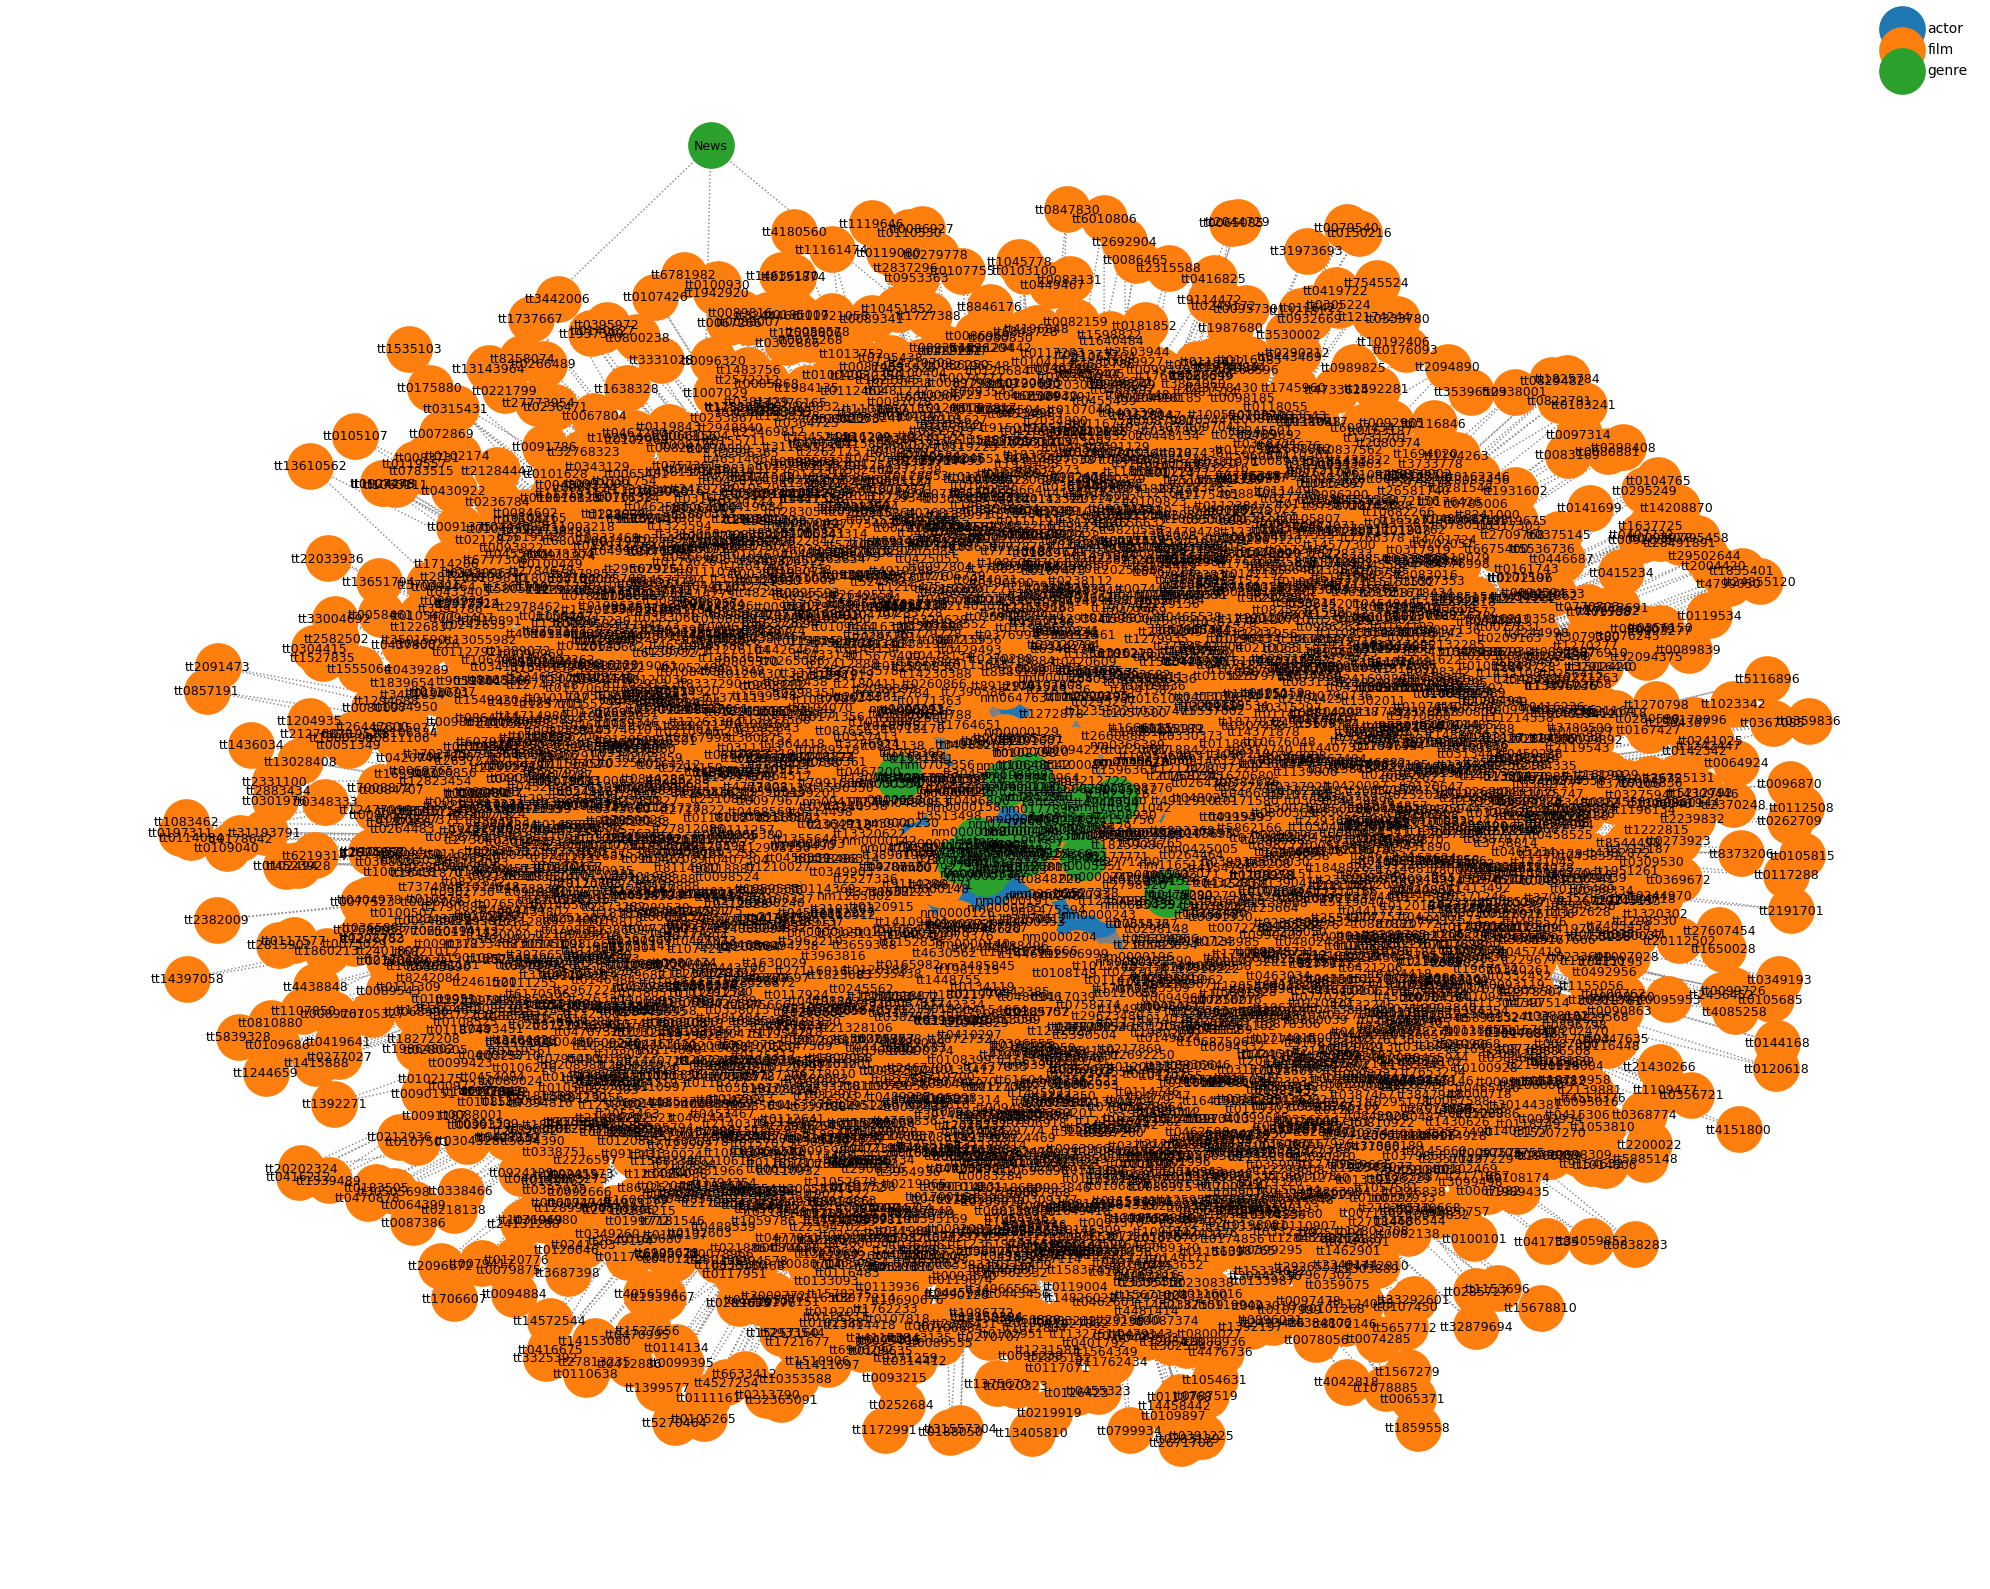

In [59]:
groups = {}
nodes = G.nodes
for node,node_type in G.nodes(data="type"):
    if groups.get(node_type) == None:
        groups[node_type] = {
            "nodes":[],
            "edges":[],
            "label":node_type
        }
    groups[node_type]["nodes"].append(node)
   # for edge in G.edges(node):
      #  groups[node_type]["edges"].append(edge)
draw_graph(G,seed=50,groups=list(groups.values()),fill_nodes=True,layout="spring",node_size=1000,node_spacing=5,figsize=(20,16))

In [60]:
actor_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'actor']
film_nodes =[n for n, d in G.nodes(data=True) if d['type'] == 'film']
genre_nodes=[n for n, d in G.nodes(data=True) if d['type'] == 'genre']
print(f"Počet herců: {len(actor_nodes)}")
print(f"Počet filmů: {len(film_nodes)}")
print(f"Počet žánrů: {len(genre_nodes)}")
print(f"Počet uzlů: {len(G.nodes)}")



100
3503
22
3625


In [62]:
G_actors = nxbp.weighted_projected_graph(G.subgraph(actor_nodes + film_nodes), actor_nodes)
df_g_actors_metrics = get_graph_metrics_df(G_actors)

In [63]:
display(df_g_actors_metrics)

shape: (1, 9)
┌───────┬─────────────┬──────────┬───────────┬───┬───────┬─────────────┬─────────────┬─────────────┐
│ Počet ┆ Tranzitivit ┆ Hustota  ┆ Klikovost ┆ … ┆ Počet ┆ Počet       ┆ Artikulace  ┆ Mosty       │
│ uzlů  ┆ a           ┆ ---      ┆ ---       ┆   ┆ mostů ┆ komponent   ┆ ---         ┆ ---         │
│ ---   ┆ ---         ┆ f64      ┆ i64       ┆   ┆ ---   ┆ ---         ┆ list[null]  ┆ list[null]  │
│ i64   ┆ f64         ┆          ┆           ┆   ┆ i64   ┆ i64         ┆             ┆             │
╞═══════╪═════════════╪══════════╪═══════════╪═══╪═══════╪═════════════╪═════════════╪═════════════╡
│ 100   ┆ 0.284118    ┆ 0.155354 ┆ 9         ┆ … ┆ 0     ┆ 1           ┆ []          ┆ []          │
└───────┴─────────────┴──────────┴───────────┴───┴───────┴─────────────┴─────────────┴─────────────┘

In [64]:
cliques_sorted = sorted(nx.find_cliques(G), key=len, reverse=True)

df_g_actors_node_metrics = get_nodes_metrics_df(G,cliques_sorted)

df_metrics = get_graph_metrics_df(G_actors)
display(df_metrics)
display(df_g_actors_metrics.sort(pl.col("klikovost"),ascending=False))

shape: (1, 9)
┌───────┬─────────────┬──────────┬───────────┬───┬───────┬─────────────┬─────────────┬─────────────┐
│ Počet ┆ Tranzitivit ┆ Hustota  ┆ Klikovost ┆ … ┆ Počet ┆ Počet       ┆ Artikulace  ┆ Mosty       │
│ uzlů  ┆ a           ┆ ---      ┆ ---       ┆   ┆ mostů ┆ komponent   ┆ ---         ┆ ---         │
│ ---   ┆ ---         ┆ f64      ┆ i64       ┆   ┆ ---   ┆ ---         ┆ list[null]  ┆ list[null]  │
│ i64   ┆ f64         ┆          ┆           ┆   ┆ i64   ┆ i64         ┆             ┆             │
╞═══════╪═════════════╪══════════╪═══════════╪═══╪═══════╪═════════════╪═════════════╪═════════════╡
│ 100   ┆ 0.284118    ┆ 0.155354 ┆ 9         ┆ … ┆ 0     ┆ 1           ┆ []          ┆ []          │
└───────┴─────────────┴──────────┴───────────┴───┴───────┴─────────────┴─────────────┴─────────────┘

uzel  klikovost  degree  eigen-vector  betweenness  closeness  \
0   nm0000168        108      35      0.022758     0.003264   0.339739   
33  nm0000115        105      10      0.021897     0.002731   0.334966   
29  nm0000246        102      19      0.021004     0.002013   0.334287   
44  nm0000134         98      27      0.023346     0.001669   0.336459   
42  nm0000553         95      23      0.018665     0.005917   0.338091   
..        ...        ...     ...           ...          ...        ...   
67  nm2962353         16      11      0.003274     0.000075   0.326046   
74  nm3915784         14       8      0.002907     0.000042   0.326457   
50  nm2143282         12      15      0.001803     0.000041   0.328886   
31  nm4004793          7       4      0.001580     0.000007   0.303645   
41  nm1775091          6       4      0.001194     0.000006   0.299232   

    clustering  
0            0  
33           0  
29           0  
44           0  
42           0  
..         ...  
67           0  
74           0  
50           0  
31           0  
41           0  

[100 rows x 7 columns]

In [65]:
display(df.sort_values("klikovost",ascending=False))

uzel  klikovost  degree  eigen-vector  betweenness  closeness  \
0   nm0000168        108      35      0.022758     0.003264   0.339739   
33  nm0000115        105      10      0.021897     0.002731   0.334966   
29  nm0000246        102      19      0.021004     0.002013   0.334287   
44  nm0000134         98      27      0.023346     0.001669   0.336459   
42  nm0000553         95      23      0.018665     0.005917   0.338091   
..        ...        ...     ...           ...          ...        ...   
67  nm2962353         16      11      0.003274     0.000075   0.326046   
74  nm3915784         14       8      0.002907     0.000042   0.326457   
50  nm2143282         12      15      0.001803     0.000041   0.328886   
31  nm4004793          7       4      0.001580     0.000007   0.303645   
41  nm1775091          6       4      0.001194     0.000006   0.299232   

    clustering  
0            0  
33           0  
29           0  
44           0  
42           0  
..         ...  
67           0  
74           0  
50           0  
31           0  
41           0  

[100 rows x 7 columns]

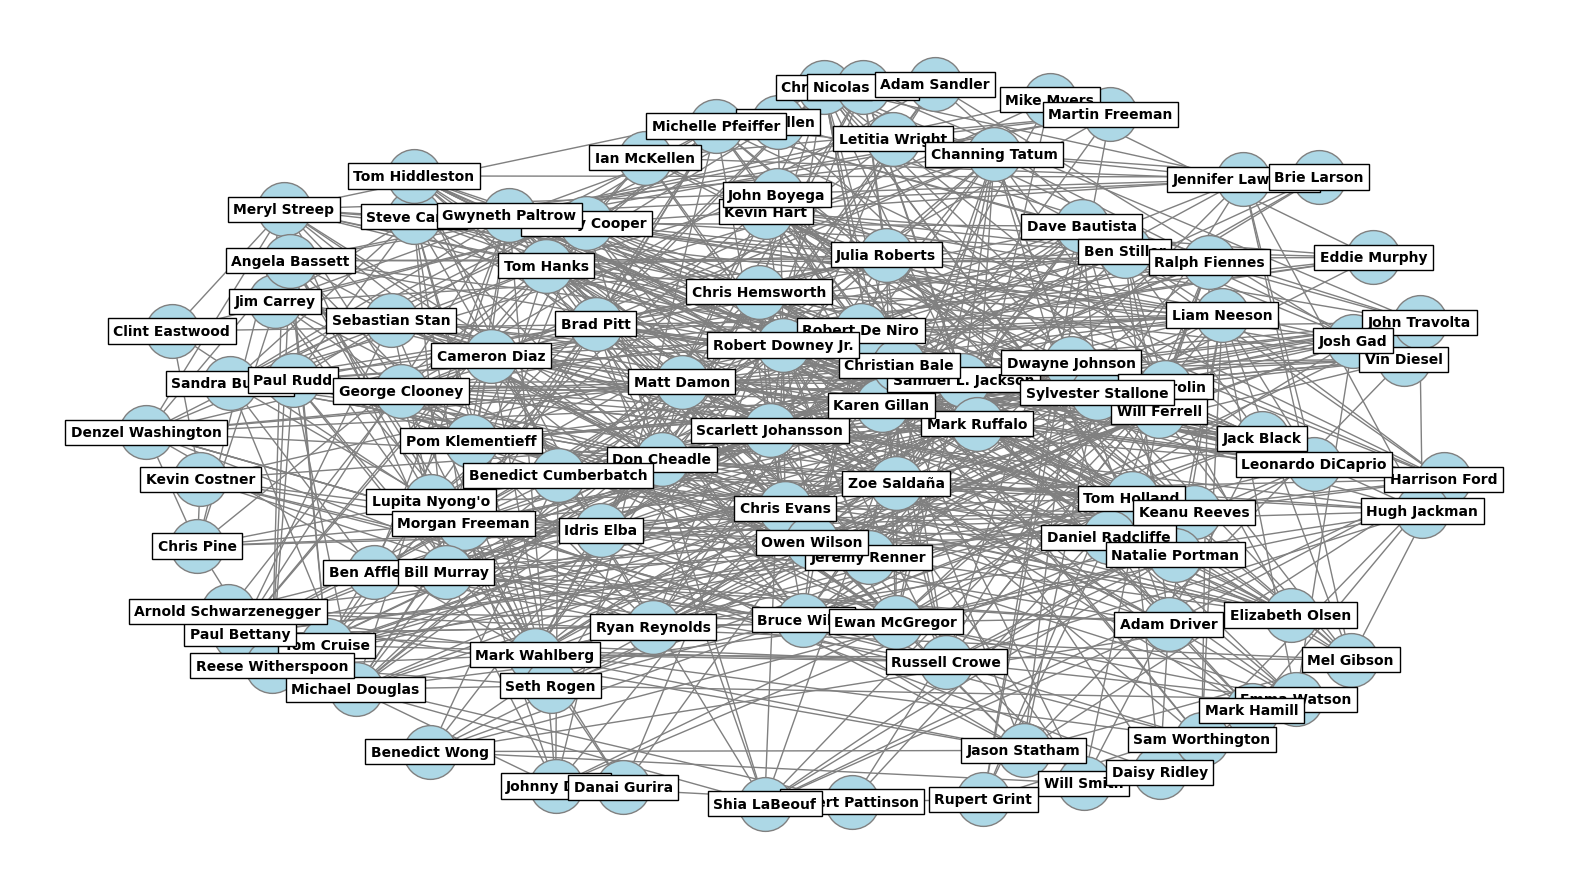

In [66]:
draw_graph(G_actors,
           seed=50,
           layout="spring",
           node_size=1500,
           node_spacing=13,
           figsize=(16,9),
           node_labels_key="primaryName",
           font_size=10,
           font_weight="bold",
           bbox=dict(facecolor="white"),
           default_edge_style="solid"
           )

In [67]:
G_genres = nxbp.weighted_projected_graph(
    G.subgraph(genre_nodes+film_nodes),
    genre_nodes)

In [68]:
df_g_genres_metrics = get_graph_metrics_df(G_genres)

In [69]:
display(df_g_genres_metrics)

shape: (1, 9)
┌───────┬─────────────┬──────────┬───────────┬───┬───────┬─────────────┬─────────────┬─────────────┐
│ Počet ┆ Tranzitivit ┆ Hustota  ┆ Klikovost ┆ … ┆ Počet ┆ Počet       ┆ Artikulace  ┆ Mosty       │
│ uzlů  ┆ a           ┆ ---      ┆ ---       ┆   ┆ mostů ┆ komponent   ┆ ---         ┆ ---         │
│ ---   ┆ ---         ┆ f64      ┆ i64       ┆   ┆ ---   ┆ ---         ┆ list[null]  ┆ list[null]  │
│ i64   ┆ f64         ┆          ┆           ┆   ┆ i64   ┆ i64         ┆             ┆             │
╞═══════╪═════════════╪══════════╪═══════════╪═══╪═══════╪═════════════╪═════════════╪═════════════╡
│ 22    ┆ 0.784346    ┆ 0.701299 ┆ 11        ┆ … ┆ 0     ┆ 1           ┆ []          ┆ []          │
└───────┴─────────────┴──────────┴───────────┴───┴───────┴─────────────┴─────────────┴─────────────┘

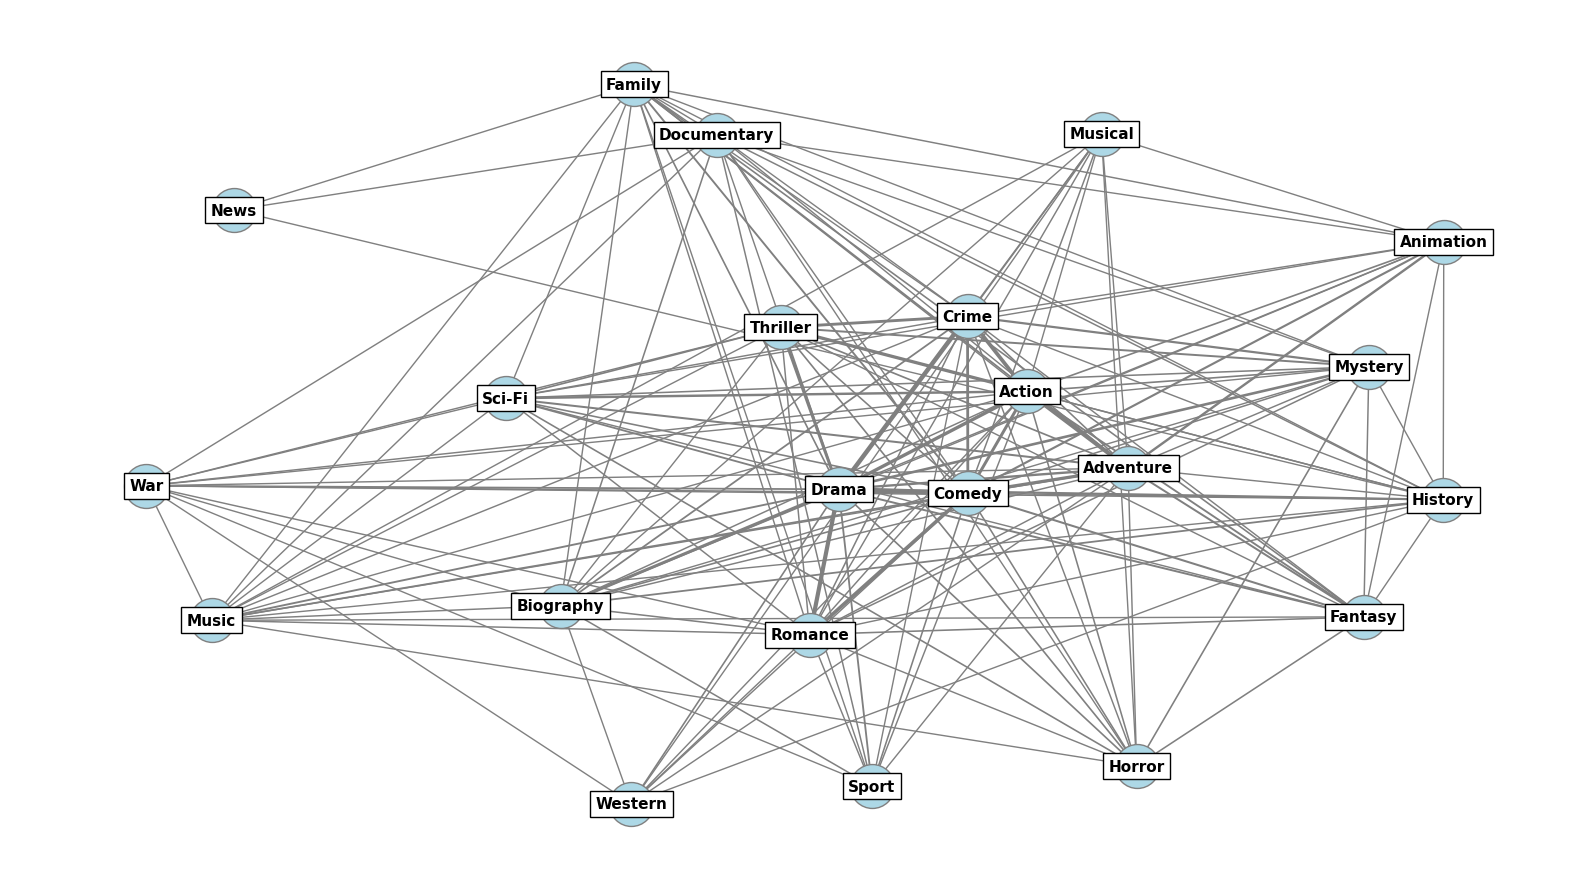

In [70]:
draw_graph(G_genres,
           seed=42,
           layout="spring",
           node_size=1000,
           node_spacing=25,
           figsize=(16,9),
           font_size=11,
           font_weight="bold",
           bbox=dict(facecolor="white"),
           default_edge_style="solid",
           max_edge_width=1.005
           )